<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/PROPHET_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using Prophet Model based on Patient Visits Medical Laboratory Data (GroupTestA)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0
Requirement already up-to-date: mxnet~=1.7 in /usr/local/lib/python3.7/dist-packages (1.8.0.post0)
Requirement already up-to-date: gluonts in /usr/local/lib/python3.7/dist-packages (0.7.6)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
  Using cached https://files.pythonhosted.org/packages/80/39/066ecde98f373430bf7a39a02d91c7075b01ef4fc928456e8e31577342d6/scipy-1.2.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: pmdarima 1.8.2 has requirement scipy>=1.3.2, but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requiremen

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1348 non-null   object
 1   hm        1348 non-null   int64 
 2   hm_aw     1348 non-null   int64 
 3   hm_am     1348 non-null   int64 
 4   cc        1348 non-null   int64 
 5   cc_aw     1348 non-null   int64 
 6   cc_am     1348 non-null   int64 
 7   day_week  1348 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 84.4+ KB


In [5]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


## **Step#2 Data Processing**

### **Picking Variable**

In [6]:
multi_prophet_df = data.reset_index()[['date', 'day_week', 'hm', 'hm_aw', 'hm_am']].rename({'date': 'ds', 'hm':'y', 'day_week': 'wd', 'hm_aw': 'aw', 'hm_am': 'am'})

In [7]:
multi_prophet_df

,date,day_week,hm,hm_aw,hm_am
0,7/1/2017,6,66,48,63
1,7/2/2017,7,53,53,62
2,7/3/2017,1,74,54,59
3,7/4/2017,2,87,56,57
4,7/5/2017,3,95,62,58
...,...,...,...,...,...
1343,3/5/2021,5,45,58,52
1344,3/6/2021,6,51,59,52
1345,3/7/2021,7,44,59,52
1346,3/8/2021,1,49,59,51


In [8]:
multi_prophet_df = pd.DataFrame({'ds': multi_prophet_df.date,
                                 'y' : multi_prophet_df.hm,
                                 'wd' : multi_prophet_df.day_week,
                                 'aw' : multi_prophet_df.hm_aw,
                                 'am' : multi_prophet_df.hm_am})

In [9]:
multi_prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1347
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      1348 non-null   object
 1   y       1348 non-null   int64 
 2   wd      1348 non-null   int64 
 3   aw      1348 non-null   int64 
 4   am      1348 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 63.2+ KB


In [10]:
multi_prophet_df.head()

,ds,y,wd,aw,am
0,7/1/2017,66,6,48,63
1,7/2/2017,53,7,53,62
2,7/3/2017,74,1,54,59
3,7/4/2017,87,2,56,57
4,7/5/2017,95,3,62,58


In [11]:
def wd(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0

### **Stationary Test**

In [12]:
df = multi_prophet_df.loc[:,['y','am','aw','wd']]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       1348 non-null   int64
 1   am      1348 non-null   int64
 2   aw      1348 non-null   int64
 3   wd      1348 non-null   int64
dtypes: int64(4)
memory usage: 52.7 KB


In [14]:
#creating test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationary(df):

  #Perform Dicky Fuller Test:
  print ('Result of Dicky-Fuller Test:')
  dftest = adfuller(df, autolag='AIC')
  dfoutput = pd.Series(df[0:4], 
                       index=['Test Statistic','p-value','#Lags Used',
                              'Number of Observations Used'])
  
  for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

In [15]:
#Loop to check all columns of the DF
import functools
df.apply(functools.partial(test_stationary))

Result of Dicky-Fuller Test:
Test Statistic                    nan
p-value                           nan
#Lags Used                        nan
Number of Observations Used       nan
Critical Value (1%)           -3.4353
Critical Value (5%)           -2.8637
Critical Value (10%)          -2.5679
Name: y, dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                    nan
p-value                           nan
#Lags Used                        nan
Number of Observations Used       nan
Critical Value (1%)           -3.4353
Critical Value (5%)           -2.8637
Critical Value (10%)          -2.5679
Name: am, dtype: float64
Result of Dicky-Fuller Test:
Test Statistic                    nan
p-value                           nan
#Lags Used                        nan
Number of Observations Used       nan
Critical Value (1%)           -3.4353
Critical Value (5%)           -2.8637
Critical Value (10%)          -2.5679
Name: aw, dtype: float64
Result of Dicky-Fuller Test:
Test Statist

y     None
am    None
aw    None
wd    None
dtype: object

### **Differencing**

In [16]:
df_diff = df.diff().dropna()
df_diff

,y,am,aw,wd
1,-13.0000,-1.0000,5.0000,1.0000
2,21.0000,-3.0000,1.0000,-6.0000
3,13.0000,-2.0000,2.0000,1.0000
4,8.0000,1.0000,6.0000,1.0000
5,-1.0000,0.0000,6.0000,1.0000
...,...,...,...,...
1343,-18.0000,1.0000,0.0000,1.0000
1344,6.0000,0.0000,1.0000,1.0000
1345,-7.0000,0.0000,0.0000,1.0000
1346,5.0000,-1.0000,0.0000,-6.0000


### **Splitting Data**

In [17]:
#creating the train and validation set
train = multi_prophet_df[:int(0.8*(len(multi_prophet_df)))]
test = multi_prophet_df[int(0.8*(len(multi_prophet_df))):]

## **Step#3 Fitting and Training Model**

In [28]:
from fbprophet import Prophet

mProp = Prophet(interval_width=0.95, daily_seasonality=True)
mProp.fit(multi_prophet_df)

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

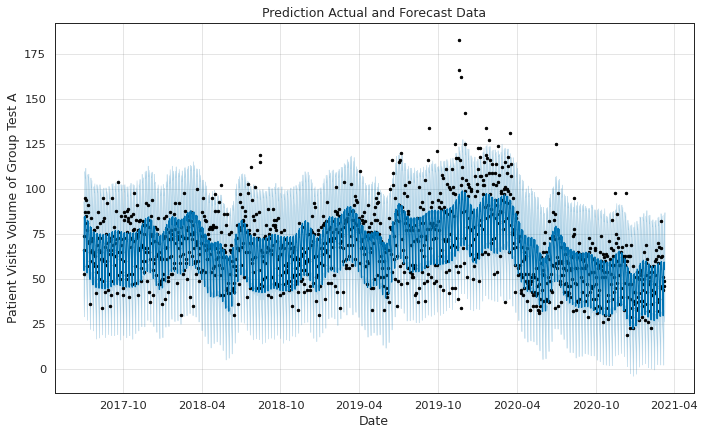

In [29]:
future = mProp.make_future_dataframe(periods=1) #we need to specify the number of days in future
prediction = mProp.predict(future)
mProp.plot(prediction)
plt.title("Prediction Actual and Forecast Data")
plt.xlabel("Date")
plt.ylabel("Patient Visits Volume of Group Test A")
plt.show()

In [30]:
forecast = mProp.predict(test.drop(columns="y"))
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-13,62.6939,20.6568,74.1518,62.6939,62.6939,-15.0695,-15.0695,-15.0695,2.0800,2.0800,2.0800,-8.6824,-8.6824,-8.6824,-8.4671,-8.4671,-8.4671,0.0000,0.0000,0.0000,47.6244
1,2020-06-14,62.5969,9.4622,62.2638,62.5969,62.5969,-25.5051,-25.5051,-25.5051,2.0800,2.0800,2.0800,-20.1206,-20.1206,-20.1206,-7.4645,-7.4645,-7.4645,0.0000,0.0000,0.0000,37.0918
2,2020-06-15,62.5000,41.5812,92.7807,62.5000,62.5000,5.2714,5.2714,5.2714,2.0800,2.0800,2.0800,9.6128,9.6128,9.6128,-6.4214,-6.4214,-6.4214,0.0000,0.0000,0.0000,67.7714
3,2020-06-16,62.4031,36.9674,89.9131,62.4031,62.4031,2.4138,2.4138,2.4138,2.0800,2.0800,2.0800,5.6838,5.6838,5.6838,-5.3500,-5.3500,-5.3500,0.0000,0.0000,0.0000,64.8169
4,2020-06-17,62.3061,43.1809,95.0495,62.3061,62.3061,7.8905,7.8905,7.8905,2.0800,2.0800,2.0800,10.0734,10.0734,10.0734,-4.2629,-4.2629,-4.2629,0.0000,0.0000,0.0000,70.1966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2021-03-05,37.0055,22.0641,76.1441,37.0055,37.0055,11.6030,11.6030,11.6030,2.0800,2.0800,2.0800,-1.1542,-1.1542,-1.1542,10.6772,10.6772,10.6772,0.0000,0.0000,0.0000,48.6085
266,2021-03-06,36.9086,15.3352,67.6814,36.9086,36.9086,4.1525,4.1525,4.1525,2.0800,2.0800,2.0800,-8.6824,-8.6824,-8.6824,10.7548,10.7548,10.7548,0.0000,0.0000,0.0000,41.0611
267,2021-03-07,36.8117,2.5921,57.6666,36.8117,36.8117,-7.2433,-7.2433,-7.2433,2.0800,2.0800,2.0800,-20.1206,-20.1206,-20.1206,10.7973,10.7973,10.7973,0.0000,0.0000,0.0000,29.5684
268,2021-03-08,36.7147,31.2644,87.3975,36.7147,36.7147,22.4970,22.4970,22.4970,2.0800,2.0800,2.0800,9.6128,9.6128,9.6128,10.8042,10.8042,10.8042,0.0000,0.0000,0.0000,59.2117


In [31]:
# Calculating the RMSE of the model

mse = mean_squared_error(test['y'], forecast['yhat'])
rmse = sqrt(mean_squared_error(test['y'], forecast['yhat']))

print('mse score :', mse)
print('rmse score :', rmse)

mse score : 123.3659596075607
rmse score : 11.10702298582121
